In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.4.0 True
2.4.0
10.1
GCC 7.3


In [2]:
import itertools
import logging
import os.path as osp
import tempfile

import mmcv
import numpy as np
from mmcv.utils import print_log
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from terminaltables import AsciiTable

from mmdet.core import eval_recalls
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

try:
    import pycocotools
    assert pycocotools.__version__ >= '12.0.2'
except AssertionError:
    raise AssertionError('Incompatible version of pycocotools is installed. '
                         'Run pip uninstall pycocotools first. Then run pip '
                         'install mmpycocotools to install open-mmlab forked '
                         'pycocotools.')

@DATASETS.register_module()
class LotteDataset(CustomDataset):

    CLASSES = ('ID_gum', 'buttering', 'couque_coffee', 'chocopie', 'cidar', 
               'couque_white', 'coke', 'diget_ori', 'diget_choco', 'gumi_gumi', 
               'homerunball', 'jjolbyung_noodle', 'juicyfresh', 'jjolbyung_ori', 
               'spearmint', 'squid_peanut', 'samdasu', 'tuna', 'toreta', 
               'vita500', 'welchs', 'zec')

    def load_annotations(self, ann_file):
        """Load annotation from COCO style annotation file.

        Args:
            ann_file (str): Path of annotation file.

        Returns:
            list[dict]: Annotation info from COCO api.
        """

        self.coco = COCO(ann_file)
        self.cat_ids = self.coco.get_cat_ids(cat_names=self.CLASSES)
        self.cat2label = {cat_id: i for i, cat_id in enumerate(self.cat_ids)}
        self.img_ids = self.coco.get_img_ids()
        data_infos = []
        for i in self.img_ids:
            info = self.coco.load_imgs([i])[0]
            info['filename'] = info['file_name']
            data_infos.append(info)
        return data_infos

    def get_ann_info(self, idx):
        """Get COCO annotation by index.

        Args:
            idx (int): Index of data.

        Returns:
            dict: Annotation info of specified index.
        """

        img_id = self.data_infos[idx]['id']
        ann_ids = self.coco.get_ann_ids(img_ids=[img_id])
        ann_info = self.coco.load_anns(ann_ids)
        return self._parse_ann_info(self.data_infos[idx], ann_info)

    def get_cat_ids(self, idx):
        """Get COCO category ids by index.

        Args:
            idx (int): Index of data.

        Returns:
            list[int]: All categories in the image of specified index.
        """

        img_id = self.data_infos[idx]['id']
        ann_ids = self.coco.get_ann_ids(img_ids=[img_id])
        ann_info = self.coco.load_anns(ann_ids)
        return [ann['category_id'] for ann in ann_info]

    def _filter_imgs(self, min_size=32):
        """Filter images too small or without ground truths."""
        valid_inds = []
        ids_with_ann = set(_['image_id'] for _ in self.coco.anns.values())
        for i, img_info in enumerate(self.data_infos):
            if self.filter_empty_gt and self.img_ids[i] not in ids_with_ann:
                continue
            if min(img_info['width'], img_info['height']) >= min_size:
                valid_inds.append(i)
        return valid_inds

    def get_subset_by_classes(self):
        """Get img ids that contain any category in class_ids.

        Different from the coco.getImgIds(), this function returns the id if
        the img contains one of the categories rather than all.

        Args:
            class_ids (list[int]): list of category ids

        Return:
            ids (list[int]): integer list of img ids
        """

        ids = set()
        for i, class_id in enumerate(self.cat_ids):
            ids |= set(self.coco.cat_img_map[class_id])
        self.img_ids = list(ids)

        data_infos = []
        for i in self.img_ids:
            info = self.coco.load_imgs([i])[0]
            info['filename'] = info['file_name']
            data_infos.append(info)
        return data_infos

    def _parse_ann_info(self, img_info, ann_info):
        """Parse bbox and mask annotation.

        Args:
            ann_info (list[dict]): Annotation info of an image.
            with_mask (bool): Whether to parse mask annotations.

        Returns:
            dict: A dict containing the following keys: bboxes, bboxes_ignore,\
                labels, masks, seg_map. "masks" are raw annotations and not \
                decoded into binary masks.
        """
        gt_bboxes = []
        gt_labels = []
        gt_bboxes_ignore = []
        gt_masks_ann = []
        for i, ann in enumerate(ann_info):
            if ann.get('ignore', False):
                continue
            x1, y1, w, h = ann['bbox']
            inter_w = max(0, min(x1 + w, img_info['width']) - max(x1, 0))
            inter_h = max(0, min(y1 + h, img_info['height']) - max(y1, 0))
            if inter_w * inter_h == 0:
                continue
            if ann['area'] <= 0 or w < 1 or h < 1:
                continue
            if ann['category_id'] not in self.cat_ids:
                continue
            bbox = [x1, y1, x1 + w, y1 + h]
            if ann.get('iscrowd', False):
                gt_bboxes_ignore.append(bbox)
            else:
                gt_bboxes.append(bbox)
                gt_labels.append(self.cat2label[ann['category_id']])
                gt_masks_ann.append(ann.get('segmentation', None))

        if gt_bboxes:
            gt_bboxes = np.array(gt_bboxes, dtype=np.float32)
            gt_labels = np.array(gt_labels, dtype=np.int64)
        else:
            gt_bboxes = np.zeros((0, 4), dtype=np.float32)
            gt_labels = np.array([], dtype=np.int64)

        if gt_bboxes_ignore:
            gt_bboxes_ignore = np.array(gt_bboxes_ignore, dtype=np.float32)
        else:
            gt_bboxes_ignore = np.zeros((0, 4), dtype=np.float32)

        seg_map = img_info['filename'].replace('jpg', 'png')

        ann = dict(
            bboxes=gt_bboxes,
            labels=gt_labels,
            bboxes_ignore=gt_bboxes_ignore,
            masks=gt_masks_ann,
            seg_map=seg_map)

        return ann

In [3]:
from mmcv import Config
cfg = Config.fromfile('./mmdetection/configs/cascade_rcnn/cascade_rcnn_r101_fpn_1x_coco.py')

In [4]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'LotteDataset'
cfg.data_root = 'datasets/'

cfg.data.train.type = 'LotteDataset'
cfg.data.train.data_root = 'datasets/'
cfg.data.train.ann_file = 'train/traincoco.json'
cfg.data.train.img_prefix = 'train/images/'

cfg.data.val.type = 'LotteDataset'
cfg.data.val.data_root = 'datasets/'
cfg.data.val.ann_file = 'val/valcoco.json'
cfg.data.val.img_prefix = 'val/images/'

cfg.data.test.type = 'LotteDataset'
cfg.data.test.data_root = 'datasets/'
cfg.data.test.ann_file = 'test/testcoco.json'
cfg.data.test.img_prefix = 'test/images/'

# num classes of the model in box head
for i, head in enumerate(cfg.model.roi_head.bbox_head):
    cfg.model.roi_head.bbox_head[i].num_classes = 22
# cfg.load_from = 'checkpoints/cascade_rcnn_r50_rfp_1x_coco-8cf51bfd.pth'
cfg.work_dir = './tutorial_exps'

# original learning rate는 GPU가 8개이므로, 자신의 GPU의 개수에 맞게 변형
cfg.optimizer.lr = 0.02 / 8 # 한 개만 쓸거니까
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

cfg.evaluation.metric = 'mAP'
# set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# ㄴet seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='CascadeRCNN',
    pretrained='torchvision://resnet101',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(

In [5]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# dataset 구축
datasets = [build_dataset(cfg.data.train)]

# detector 구축
model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2020-10-01 16:55:53,583 - mmdet - INFO - load model from: torchvision://resnet101
2020-10-01 16:55:53,783 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2020-10-01 16:55:55,195 - mmdet - INFO - Start running, host: jmh@jmh-GE75-Raider-10SF, work_dir: /home/jmh/content/mmdetection_object_detection_demo/tutorial_exps
2020-10-01 16:55:55,196 - mmdet - INFO - workflow: [('train', 1)], max: 12 epochs


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


2020-10-01 16:56:05,548 - mmdet - INFO - Epoch [1][10/601]	lr: 2.500e-03, eta: 1:54:56, time: 0.958, data_time: 0.218, memory: 6006, loss_rpn_cls: 0.5489, loss_rpn_bbox: 0.0524, s0.loss_cls: 1.3013, s0.acc: 82.6953, s0.loss_bbox: 0.1625, s1.loss_cls: 0.5635, s1.acc: 84.7754, s1.loss_bbox: 0.0541, s2.loss_cls: 0.3025, s2.acc: 76.1035, s2.loss_bbox: 0.0075, loss: 2.9926
2020-10-01 16:56:12,366 - mmdet - INFO - Epoch [1][20/601]	lr: 2.500e-03, eta: 1:38:15, time: 0.682, data_time: 0.004, memory: 6006, loss_rpn_cls: 0.1721, loss_rpn_bbox: 0.0455, s0.loss_cls: 0.9002, s0.acc: 84.3164, s0.loss_bbox: 0.3883, s1.loss_cls: 0.2424, s1.acc: 93.6035, s1.loss_bbox: 0.1131, s2.loss_cls: 0.0690, s2.acc: 97.1875, s2.loss_bbox: 0.0150, loss: 1.9455
2020-10-01 16:56:19,079 - mmdet - INFO - Epoch [1][30/601]	lr: 2.500e-03, eta: 1:32:11, time: 0.671, data_time: 0.004, memory: 6006, loss_rpn_cls: 0.1315, loss_rpn_bbox: 0.0522, s0.loss_cls: 0.8930, s0.acc: 83.7207, s0.loss_bbox: 0.3954, s1.loss_cls: 0.2606,

2020-10-01 16:58:43,106 - mmdet - INFO - Epoch [1][240/601]	lr: 2.500e-03, eta: 1:20:55, time: 0.727, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0196, loss_rpn_bbox: 0.0357, s0.loss_cls: 0.5277, s0.acc: 84.8438, s0.loss_bbox: 0.2206, s1.loss_cls: 0.2665, s1.acc: 85.4580, s1.loss_bbox: 0.1782, s2.loss_cls: 0.1573, s2.acc: 83.5837, s2.loss_bbox: 0.1537, loss: 1.5592
2020-10-01 16:58:49,657 - mmdet - INFO - Epoch [1][250/601]	lr: 2.500e-03, eta: 1:20:36, time: 0.655, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0221, loss_rpn_bbox: 0.0356, s0.loss_cls: 0.4927, s0.acc: 86.1133, s0.loss_bbox: 0.2033, s1.loss_cls: 0.2430, s1.acc: 86.3390, s1.loss_bbox: 0.2075, s2.loss_cls: 0.1426, s2.acc: 84.3611, s2.loss_bbox: 0.1541, loss: 1.5008
2020-10-01 16:58:56,209 - mmdet - INFO - Epoch [1][260/601]	lr: 2.500e-03, eta: 1:20:19, time: 0.655, data_time: 0.004, memory: 6006, loss_rpn_cls: 0.0165, loss_rpn_bbox: 0.0339, s0.loss_cls: 0.4622, s0.acc: 85.5371, s0.loss_bbox: 0.1707, s1.loss_cls: 0.21

2020-10-01 17:01:25,413 - mmdet - INFO - Epoch [1][470/601]	lr: 2.500e-03, eta: 1:18:45, time: 0.712, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0092, loss_rpn_bbox: 0.0204, s0.loss_cls: 0.2705, s0.acc: 92.0020, s0.loss_bbox: 0.1524, s1.loss_cls: 0.1224, s1.acc: 93.5091, s1.loss_bbox: 0.1625, s2.loss_cls: 0.0698, s2.acc: 93.4279, s2.loss_bbox: 0.1222, loss: 0.9294
2020-10-01 17:01:32,173 - mmdet - INFO - Epoch [1][480/601]	lr: 2.500e-03, eta: 1:18:35, time: 0.676, data_time: 0.004, memory: 6006, loss_rpn_cls: 0.0089, loss_rpn_bbox: 0.0209, s0.loss_cls: 0.2950, s0.acc: 92.0605, s0.loss_bbox: 0.1294, s1.loss_cls: 0.1276, s1.acc: 94.2325, s1.loss_bbox: 0.1577, s2.loss_cls: 0.0766, s2.acc: 92.3221, s2.loss_bbox: 0.1231, loss: 0.9391
2020-10-01 17:01:39,069 - mmdet - INFO - Epoch [1][490/601]	lr: 2.500e-03, eta: 1:18:26, time: 0.690, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0147, loss_rpn_bbox: 0.0235, s0.loss_cls: 0.2809, s0.acc: 92.5488, s0.loss_bbox: 0.1359, s1.loss_cls: 0.11

2020-10-01 17:04:09,699 - mmdet - INFO - Epoch [2][100/601]	lr: 2.500e-03, eta: 1:16:19, time: 0.734, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0110, loss_rpn_bbox: 0.0188, s0.loss_cls: 0.2234, s0.acc: 94.1992, s0.loss_bbox: 0.1176, s1.loss_cls: 0.0989, s1.acc: 95.7122, s1.loss_bbox: 0.1315, s2.loss_cls: 0.0562, s2.acc: 95.1138, s2.loss_bbox: 0.1070, loss: 0.7645
2020-10-01 17:04:16,463 - mmdet - INFO - Epoch [2][110/601]	lr: 2.500e-03, eta: 1:16:09, time: 0.676, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0079, loss_rpn_bbox: 0.0213, s0.loss_cls: 0.2372, s0.acc: 92.8906, s0.loss_bbox: 0.1328, s1.loss_cls: 0.1032, s1.acc: 94.2431, s1.loss_bbox: 0.1471, s2.loss_cls: 0.0614, s2.acc: 92.7404, s2.loss_bbox: 0.1279, loss: 0.8388
2020-10-01 17:04:23,874 - mmdet - INFO - Epoch [2][120/601]	lr: 2.500e-03, eta: 1:16:06, time: 0.741, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0064, loss_rpn_bbox: 0.0162, s0.loss_cls: 0.2387, s0.acc: 93.7598, s0.loss_bbox: 0.0911, s1.loss_cls: 0.11

2020-10-01 17:06:49,724 - mmdet - INFO - Epoch [2][330/601]	lr: 2.500e-03, eta: 1:13:25, time: 0.731, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0049, loss_rpn_bbox: 0.0193, s0.loss_cls: 0.2145, s0.acc: 94.8730, s0.loss_bbox: 0.0946, s1.loss_cls: 0.1018, s1.acc: 96.2816, s1.loss_bbox: 0.1109, s2.loss_cls: 0.0561, s2.acc: 96.4619, s2.loss_bbox: 0.0971, loss: 0.6992
2020-10-01 17:06:56,596 - mmdet - INFO - Epoch [2][340/601]	lr: 2.500e-03, eta: 1:13:17, time: 0.687, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0050, loss_rpn_bbox: 0.0139, s0.loss_cls: 0.1527, s0.acc: 95.2734, s0.loss_bbox: 0.0908, s1.loss_cls: 0.0655, s1.acc: 96.6282, s1.loss_bbox: 0.0997, s2.loss_cls: 0.0356, s2.acc: 96.2240, s2.loss_bbox: 0.0873, loss: 0.5505
2020-10-01 17:07:03,769 - mmdet - INFO - Epoch [2][350/601]	lr: 2.500e-03, eta: 1:13:12, time: 0.717, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0055, loss_rpn_bbox: 0.0154, s0.loss_cls: 0.2227, s0.acc: 94.8340, s0.loss_bbox: 0.1027, s1.loss_cls: 0.10

2020-10-01 17:09:30,409 - mmdet - INFO - Epoch [2][560/601]	lr: 2.500e-03, eta: 1:10:41, time: 0.699, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0046, loss_rpn_bbox: 0.0150, s0.loss_cls: 0.2469, s0.acc: 95.3516, s0.loss_bbox: 0.1114, s1.loss_cls: 0.1288, s1.acc: 96.4564, s1.loss_bbox: 0.1120, s2.loss_cls: 0.0692, s2.acc: 96.7621, s2.loss_bbox: 0.0965, loss: 0.7844
2020-10-01 17:09:37,688 - mmdet - INFO - Epoch [2][570/601]	lr: 2.500e-03, eta: 1:10:35, time: 0.728, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0042, loss_rpn_bbox: 0.0145, s0.loss_cls: 0.2423, s0.acc: 95.0000, s0.loss_bbox: 0.1012, s1.loss_cls: 0.1320, s1.acc: 96.0715, s1.loss_bbox: 0.1130, s2.loss_cls: 0.0761, s2.acc: 95.3439, s2.loss_bbox: 0.1094, loss: 0.7926
2020-10-01 17:09:44,994 - mmdet - INFO - Epoch [2][580/601]	lr: 2.500e-03, eta: 1:10:30, time: 0.731, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0057, loss_rpn_bbox: 0.0156, s0.loss_cls: 0.2626, s0.acc: 95.8008, s0.loss_bbox: 0.0778, s1.loss_cls: 0.14

2020-10-01 17:12:16,194 - mmdet - INFO - Epoch [3][190/601]	lr: 2.500e-03, eta: 1:08:12, time: 0.686, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0047, loss_rpn_bbox: 0.0117, s0.loss_cls: 0.2143, s0.acc: 94.7852, s0.loss_bbox: 0.0772, s1.loss_cls: 0.1217, s1.acc: 95.9683, s1.loss_bbox: 0.1014, s2.loss_cls: 0.0708, s2.acc: 95.8956, s2.loss_bbox: 0.1007, loss: 0.7025
2020-10-01 17:12:23,054 - mmdet - INFO - Epoch [3][200/601]	lr: 2.500e-03, eta: 1:08:04, time: 0.686, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0032, loss_rpn_bbox: 0.0115, s0.loss_cls: 0.1876, s0.acc: 95.7910, s0.loss_bbox: 0.0734, s1.loss_cls: 0.1074, s1.acc: 96.5756, s1.loss_bbox: 0.0854, s2.loss_cls: 0.0625, s2.acc: 96.3792, s2.loss_bbox: 0.0822, loss: 0.6133
2020-10-01 17:12:30,486 - mmdet - INFO - Epoch [3][210/601]	lr: 2.500e-03, eta: 1:07:59, time: 0.743, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0051, loss_rpn_bbox: 0.0150, s0.loss_cls: 0.1740, s0.acc: 96.1719, s0.loss_bbox: 0.0751, s1.loss_cls: 0.10

2020-10-01 17:14:55,038 - mmdet - INFO - Epoch [3][420/601]	lr: 2.500e-03, eta: 1:05:20, time: 0.688, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0106, s0.loss_cls: 0.1487, s0.acc: 96.0742, s0.loss_bbox: 0.0745, s1.loss_cls: 0.0806, s1.acc: 97.5188, s1.loss_bbox: 0.0964, s2.loss_cls: 0.0510, s2.acc: 96.5032, s2.loss_bbox: 0.0958, loss: 0.5605
2020-10-01 17:15:01,889 - mmdet - INFO - Epoch [3][430/601]	lr: 2.500e-03, eta: 1:05:13, time: 0.685, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0042, loss_rpn_bbox: 0.0119, s0.loss_cls: 0.1177, s0.acc: 96.2988, s0.loss_bbox: 0.0825, s1.loss_cls: 0.0520, s1.acc: 97.4240, s1.loss_bbox: 0.0905, s2.loss_cls: 0.0309, s2.acc: 97.1552, s2.loss_bbox: 0.0838, loss: 0.4734
2020-10-01 17:15:09,039 - mmdet - INFO - Epoch [3][440/601]	lr: 2.500e-03, eta: 1:05:06, time: 0.715, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0045, loss_rpn_bbox: 0.0121, s0.loss_cls: 0.1756, s0.acc: 96.3086, s0.loss_bbox: 0.0689, s1.loss_cls: 0.10

2020-10-01 17:17:39,978 - mmdet - INFO - Epoch [4][50/601]	lr: 2.500e-03, eta: 1:02:44, time: 0.716, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0047, loss_rpn_bbox: 0.0096, s0.loss_cls: 0.1426, s0.acc: 96.9141, s0.loss_bbox: 0.0620, s1.loss_cls: 0.1067, s1.acc: 97.6651, s1.loss_bbox: 0.0841, s2.loss_cls: 0.0667, s2.acc: 97.5255, s2.loss_bbox: 0.0761, loss: 0.5524
2020-10-01 17:17:46,559 - mmdet - INFO - Epoch [4][60/601]	lr: 2.500e-03, eta: 1:02:36, time: 0.658, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0074, s0.loss_cls: 0.1147, s0.acc: 96.7188, s0.loss_bbox: 0.0585, s1.loss_cls: 0.0704, s1.acc: 97.6983, s1.loss_bbox: 0.0797, s2.loss_cls: 0.0414, s2.acc: 97.8697, s2.loss_bbox: 0.0751, loss: 0.4492
2020-10-01 17:17:53,687 - mmdet - INFO - Epoch [4][70/601]	lr: 2.500e-03, eta: 1:02:29, time: 0.713, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0033, loss_rpn_bbox: 0.0096, s0.loss_cls: 0.1411, s0.acc: 96.8164, s0.loss_bbox: 0.0546, s1.loss_cls: 0.0921,

2020-10-01 17:20:19,870 - mmdet - INFO - Epoch [4][280/601]	lr: 2.500e-03, eta: 0:59:59, time: 0.739, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0094, s0.loss_cls: 0.1073, s0.acc: 97.2461, s0.loss_bbox: 0.0557, s1.loss_cls: 0.1019, s1.acc: 97.9748, s1.loss_bbox: 0.0719, s2.loss_cls: 0.0682, s2.acc: 98.5081, s2.loss_bbox: 0.0731, loss: 0.4888
2020-10-01 17:20:26,597 - mmdet - INFO - Epoch [4][290/601]	lr: 2.500e-03, eta: 0:59:51, time: 0.673, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0039, loss_rpn_bbox: 0.0107, s0.loss_cls: 0.1260, s0.acc: 96.1523, s0.loss_bbox: 0.0658, s1.loss_cls: 0.0783, s1.acc: 97.4150, s1.loss_bbox: 0.0920, s2.loss_cls: 0.0513, s2.acc: 97.4247, s2.loss_bbox: 0.0878, loss: 0.5157
2020-10-01 17:20:33,766 - mmdet - INFO - Epoch [4][300/601]	lr: 2.500e-03, eta: 0:59:44, time: 0.717, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0103, s0.loss_cls: 0.1122, s0.acc: 97.0410, s0.loss_bbox: 0.0501, s1.loss_cls: 0.08

2020-10-01 17:23:00,670 - mmdet - INFO - Epoch [4][510/601]	lr: 2.500e-03, eta: 0:57:16, time: 0.688, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0101, s0.loss_cls: 0.1343, s0.acc: 95.9180, s0.loss_bbox: 0.0643, s1.loss_cls: 0.0713, s1.acc: 97.3894, s1.loss_bbox: 0.0941, s2.loss_cls: 0.0529, s2.acc: 96.7914, s2.loss_bbox: 0.0892, loss: 0.5189
2020-10-01 17:23:07,980 - mmdet - INFO - Epoch [4][520/601]	lr: 2.500e-03, eta: 0:57:10, time: 0.731, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0106, s0.loss_cls: 0.1422, s0.acc: 95.2344, s0.loss_bbox: 0.0610, s1.loss_cls: 0.0931, s1.acc: 96.4369, s1.loss_bbox: 0.0763, s2.loss_cls: 0.0655, s2.acc: 96.6877, s2.loss_bbox: 0.0749, loss: 0.5271
2020-10-01 17:23:15,389 - mmdet - INFO - Epoch [4][530/601]	lr: 2.500e-03, eta: 0:57:03, time: 0.741, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0063, loss_rpn_bbox: 0.0121, s0.loss_cls: 0.1358, s0.acc: 95.7617, s0.loss_bbox: 0.0632, s1.loss_cls: 0.09

2020-10-01 17:25:46,374 - mmdet - INFO - Epoch [5][140/601]	lr: 2.500e-03, eta: 0:54:39, time: 0.684, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0059, loss_rpn_bbox: 0.0113, s0.loss_cls: 0.1271, s0.acc: 95.7031, s0.loss_bbox: 0.0685, s1.loss_cls: 0.0684, s1.acc: 97.0467, s1.loss_bbox: 0.0849, s2.loss_cls: 0.0494, s2.acc: 96.9972, s2.loss_bbox: 0.0772, loss: 0.4929
2020-10-01 17:25:52,945 - mmdet - INFO - Epoch [5][150/601]	lr: 2.500e-03, eta: 0:54:31, time: 0.657, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0031, loss_rpn_bbox: 0.0088, s0.loss_cls: 0.0886, s0.acc: 96.9141, s0.loss_bbox: 0.0595, s1.loss_cls: 0.0482, s1.acc: 98.0280, s1.loss_bbox: 0.0753, s2.loss_cls: 0.0413, s2.acc: 97.8684, s2.loss_bbox: 0.0682, loss: 0.3930
2020-10-01 17:25:59,508 - mmdet - INFO - Epoch [5][160/601]	lr: 2.500e-03, eta: 0:54:23, time: 0.656, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0104, s0.loss_cls: 0.0867, s0.acc: 96.8652, s0.loss_bbox: 0.0600, s1.loss_cls: 0.04

2020-10-01 17:28:24,127 - mmdet - INFO - Epoch [5][370/601]	lr: 2.500e-03, eta: 0:51:51, time: 0.712, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0101, s0.loss_cls: 0.0852, s0.acc: 96.9629, s0.loss_bbox: 0.0632, s1.loss_cls: 0.0503, s1.acc: 98.1291, s1.loss_bbox: 0.0828, s2.loss_cls: 0.0543, s2.acc: 98.2828, s2.loss_bbox: 0.0781, loss: 0.4263
2020-10-01 17:28:31,038 - mmdet - INFO - Epoch [5][380/601]	lr: 2.500e-03, eta: 0:51:44, time: 0.691, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0074, s0.loss_cls: 0.0679, s0.acc: 97.5000, s0.loss_bbox: 0.0474, s1.loss_cls: 0.0348, s1.acc: 98.5700, s1.loss_bbox: 0.0695, s2.loss_cls: 0.0402, s2.acc: 98.9268, s2.loss_bbox: 0.0641, loss: 0.3333
2020-10-01 17:28:38,057 - mmdet - INFO - Epoch [5][390/601]	lr: 2.500e-03, eta: 0:51:37, time: 0.702, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0096, s0.loss_cls: 0.0877, s0.acc: 96.9238, s0.loss_bbox: 0.0633, s1.loss_cls: 0.04

2020-10-01 17:31:04,149 - mmdet - INFO - Epoch [5][600/601]	lr: 2.500e-03, eta: 0:49:08, time: 0.692, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0042, loss_rpn_bbox: 0.0069, s0.loss_cls: 0.0814, s0.acc: 97.2949, s0.loss_bbox: 0.0479, s1.loss_cls: 0.0344, s1.acc: 98.3430, s1.loss_bbox: 0.0649, s2.loss_cls: 0.0306, s2.acc: 98.4656, s2.loss_bbox: 0.0655, loss: 0.3358
2020-10-01 17:31:13,879 - mmdet - INFO - Epoch [6][10/601]	lr: 2.500e-03, eta: 0:49:02, time: 0.892, data_time: 0.214, memory: 6006, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0061, s0.loss_cls: 0.0672, s0.acc: 97.6465, s0.loss_bbox: 0.0398, s1.loss_cls: 0.0297, s1.acc: 98.5195, s1.loss_bbox: 0.0588, s2.loss_cls: 0.0373, s2.acc: 98.8596, s2.loss_bbox: 0.0611, loss: 0.3014
2020-10-01 17:31:20,689 - mmdet - INFO - Epoch [6][20/601]	lr: 2.500e-03, eta: 0:48:55, time: 0.681, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0032, loss_rpn_bbox: 0.0067, s0.loss_cls: 0.0799, s0.acc: 97.2656, s0.loss_bbox: 0.0483, s1.loss_cls: 0.0307

2020-10-01 17:33:46,271 - mmdet - INFO - Epoch [6][230/601]	lr: 2.500e-03, eta: 0:46:26, time: 0.695, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0070, s0.loss_cls: 0.0746, s0.acc: 97.5195, s0.loss_bbox: 0.0366, s1.loss_cls: 0.0340, s1.acc: 98.1439, s1.loss_bbox: 0.0549, s2.loss_cls: 0.0350, s2.acc: 98.5401, s2.loss_bbox: 0.0579, loss: 0.3021
2020-10-01 17:33:52,833 - mmdet - INFO - Epoch [6][240/601]	lr: 2.500e-03, eta: 0:46:18, time: 0.656, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0055, s0.loss_cls: 0.0701, s0.acc: 97.1387, s0.loss_bbox: 0.0424, s1.loss_cls: 0.0229, s1.acc: 98.4386, s1.loss_bbox: 0.0615, s2.loss_cls: 0.0249, s2.acc: 98.3711, s2.loss_bbox: 0.0685, loss: 0.2978
2020-10-01 17:33:59,652 - mmdet - INFO - Epoch [6][250/601]	lr: 2.500e-03, eta: 0:46:11, time: 0.682, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0074, s0.loss_cls: 0.0940, s0.acc: 96.6113, s0.loss_bbox: 0.0468, s1.loss_cls: 0.03

2020-10-01 17:36:25,474 - mmdet - INFO - Epoch [6][460/601]	lr: 2.500e-03, eta: 0:43:43, time: 0.701, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0032, loss_rpn_bbox: 0.0071, s0.loss_cls: 0.0908, s0.acc: 97.1387, s0.loss_bbox: 0.0456, s1.loss_cls: 0.0388, s1.acc: 97.9950, s1.loss_bbox: 0.0623, s2.loss_cls: 0.0414, s2.acc: 98.4368, s2.loss_bbox: 0.0620, loss: 0.3511
2020-10-01 17:36:32,656 - mmdet - INFO - Epoch [6][470/601]	lr: 2.500e-03, eta: 0:43:36, time: 0.718, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0070, s0.loss_cls: 0.0944, s0.acc: 96.6992, s0.loss_bbox: 0.0466, s1.loss_cls: 0.0343, s1.acc: 98.0923, s1.loss_bbox: 0.0655, s2.loss_cls: 0.0401, s2.acc: 98.5775, s2.loss_bbox: 0.0715, loss: 0.3611
2020-10-01 17:36:39,520 - mmdet - INFO - Epoch [6][480/601]	lr: 2.500e-03, eta: 0:43:29, time: 0.686, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0060, s0.loss_cls: 0.0965, s0.acc: 97.1289, s0.loss_bbox: 0.0401, s1.loss_cls: 0.03

2020-10-01 17:39:08,574 - mmdet - INFO - Epoch [7][90/601]	lr: 2.500e-03, eta: 0:41:02, time: 0.727, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0080, s0.loss_cls: 0.0705, s0.acc: 97.5391, s0.loss_bbox: 0.0437, s1.loss_cls: 0.0248, s1.acc: 98.7053, s1.loss_bbox: 0.0550, s2.loss_cls: 0.0384, s2.acc: 98.8506, s2.loss_bbox: 0.0567, loss: 0.2988
2020-10-01 17:39:15,438 - mmdet - INFO - Epoch [7][100/601]	lr: 2.500e-03, eta: 0:40:54, time: 0.686, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0056, s0.loss_cls: 0.0731, s0.acc: 97.4316, s0.loss_bbox: 0.0378, s1.loss_cls: 0.0302, s1.acc: 98.2467, s1.loss_bbox: 0.0557, s2.loss_cls: 0.0289, s2.acc: 98.5777, s2.loss_bbox: 0.0562, loss: 0.2897
2020-10-01 17:39:22,429 - mmdet - INFO - Epoch [7][110/601]	lr: 2.500e-03, eta: 0:40:47, time: 0.699, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0067, s0.loss_cls: 0.0728, s0.acc: 97.2070, s0.loss_bbox: 0.0436, s1.loss_cls: 0.025

2020-10-01 17:41:49,050 - mmdet - INFO - Epoch [7][320/601]	lr: 2.500e-03, eta: 0:38:20, time: 0.698, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0033, loss_rpn_bbox: 0.0091, s0.loss_cls: 0.0711, s0.acc: 97.4414, s0.loss_bbox: 0.0497, s1.loss_cls: 0.0279, s1.acc: 98.1477, s1.loss_bbox: 0.0583, s2.loss_cls: 0.0276, s2.acc: 98.6142, s2.loss_bbox: 0.0538, loss: 0.3008
2020-10-01 17:41:56,309 - mmdet - INFO - Epoch [7][330/601]	lr: 2.500e-03, eta: 0:38:13, time: 0.726, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0077, s0.loss_cls: 0.0796, s0.acc: 96.6992, s0.loss_bbox: 0.0617, s1.loss_cls: 0.0294, s1.acc: 97.8146, s1.loss_bbox: 0.0710, s2.loss_cls: 0.0284, s2.acc: 97.7614, s2.loss_bbox: 0.0674, loss: 0.3472
2020-10-01 17:42:02,882 - mmdet - INFO - Epoch [7][340/601]	lr: 2.500e-03, eta: 0:38:06, time: 0.657, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0087, s0.loss_cls: 0.0677, s0.acc: 97.6270, s0.loss_bbox: 0.0473, s1.loss_cls: 0.02

2020-10-01 17:44:29,412 - mmdet - INFO - Epoch [7][550/601]	lr: 2.500e-03, eta: 0:35:38, time: 0.712, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0084, s0.loss_cls: 0.0720, s0.acc: 97.2852, s0.loss_bbox: 0.0392, s1.loss_cls: 0.0257, s1.acc: 98.3217, s1.loss_bbox: 0.0503, s2.loss_cls: 0.0186, s2.acc: 98.5980, s2.loss_bbox: 0.0483, loss: 0.2645
2020-10-01 17:44:36,395 - mmdet - INFO - Epoch [7][560/601]	lr: 2.500e-03, eta: 0:35:31, time: 0.698, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0067, s0.loss_cls: 0.0680, s0.acc: 97.1191, s0.loss_bbox: 0.0422, s1.loss_cls: 0.0218, s1.acc: 98.4835, s1.loss_bbox: 0.0571, s2.loss_cls: 0.0203, s2.acc: 98.9766, s2.loss_bbox: 0.0593, loss: 0.2776
2020-10-01 17:44:43,626 - mmdet - INFO - Epoch [7][570/601]	lr: 2.500e-03, eta: 0:35:25, time: 0.723, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0071, s0.loss_cls: 0.0853, s0.acc: 97.0117, s0.loss_bbox: 0.0473, s1.loss_cls: 0.03

2020-10-01 17:47:12,704 - mmdet - INFO - Epoch [8][180/601]	lr: 2.500e-03, eta: 0:32:57, time: 0.685, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0073, s0.loss_cls: 0.0692, s0.acc: 97.4902, s0.loss_bbox: 0.0538, s1.loss_cls: 0.0263, s1.acc: 98.3188, s1.loss_bbox: 0.0665, s2.loss_cls: 0.0179, s2.acc: 98.6817, s2.loss_bbox: 0.0647, loss: 0.3079
2020-10-01 17:47:19,815 - mmdet - INFO - Epoch [8][190/601]	lr: 2.500e-03, eta: 0:32:50, time: 0.711, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0067, s0.loss_cls: 0.0687, s0.acc: 97.4805, s0.loss_bbox: 0.0467, s1.loss_cls: 0.0231, s1.acc: 98.4227, s1.loss_bbox: 0.0601, s2.loss_cls: 0.0177, s2.acc: 98.7899, s2.loss_bbox: 0.0618, loss: 0.2870
2020-10-01 17:47:26,949 - mmdet - INFO - Epoch [8][200/601]	lr: 2.500e-03, eta: 0:32:43, time: 0.713, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0077, s0.loss_cls: 0.0702, s0.acc: 97.5391, s0.loss_bbox: 0.0409, s1.loss_cls: 0.02

2020-10-01 17:49:52,287 - mmdet - INFO - Epoch [8][410/601]	lr: 2.500e-03, eta: 0:30:15, time: 0.682, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0051, s0.loss_cls: 0.0602, s0.acc: 97.6367, s0.loss_bbox: 0.0334, s1.loss_cls: 0.0181, s1.acc: 98.7237, s1.loss_bbox: 0.0542, s2.loss_cls: 0.0121, s2.acc: 99.0443, s2.loss_bbox: 0.0558, loss: 0.2413
2020-10-01 17:49:59,226 - mmdet - INFO - Epoch [8][420/601]	lr: 2.500e-03, eta: 0:30:08, time: 0.694, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0067, s0.loss_cls: 0.0752, s0.acc: 97.2559, s0.loss_bbox: 0.0356, s1.loss_cls: 0.0254, s1.acc: 98.5545, s1.loss_bbox: 0.0521, s2.loss_cls: 0.0151, s2.acc: 98.9743, s2.loss_bbox: 0.0512, loss: 0.2642
2020-10-01 17:50:05,773 - mmdet - INFO - Epoch [8][430/601]	lr: 2.500e-03, eta: 0:30:01, time: 0.655, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0059, s0.loss_cls: 0.0641, s0.acc: 97.6270, s0.loss_bbox: 0.0396, s1.loss_cls: 0.02

2020-10-01 17:52:34,837 - mmdet - INFO - Epoch [9][40/601]	lr: 2.500e-04, eta: 0:27:34, time: 0.725, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0044, s0.loss_cls: 0.0636, s0.acc: 97.6465, s0.loss_bbox: 0.0302, s1.loss_cls: 0.0229, s1.acc: 98.5511, s1.loss_bbox: 0.0447, s2.loss_cls: 0.0186, s2.acc: 98.8840, s2.loss_bbox: 0.0473, loss: 0.2335
2020-10-01 17:52:41,890 - mmdet - INFO - Epoch [9][50/601]	lr: 2.500e-04, eta: 0:27:27, time: 0.705, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0044, s0.loss_cls: 0.0502, s0.acc: 98.2520, s0.loss_bbox: 0.0247, s1.loss_cls: 0.0157, s1.acc: 98.9292, s1.loss_bbox: 0.0335, s2.loss_cls: 0.0110, s2.acc: 99.1863, s2.loss_bbox: 0.0360, loss: 0.1768
2020-10-01 17:52:49,239 - mmdet - INFO - Epoch [9][60/601]	lr: 2.500e-04, eta: 0:27:20, time: 0.735, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0043, s0.loss_cls: 0.0558, s0.acc: 98.1641, s0.loss_bbox: 0.0234, s1.loss_cls: 0.0232,

2020-10-01 17:55:16,438 - mmdet - INFO - Epoch [9][270/601]	lr: 2.500e-04, eta: 0:24:53, time: 0.733, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0046, s0.loss_cls: 0.0517, s0.acc: 98.0859, s0.loss_bbox: 0.0276, s1.loss_cls: 0.0161, s1.acc: 98.8407, s1.loss_bbox: 0.0379, s2.loss_cls: 0.0129, s2.acc: 99.3046, s2.loss_bbox: 0.0400, loss: 0.1925
2020-10-01 17:55:23,266 - mmdet - INFO - Epoch [9][280/601]	lr: 2.500e-04, eta: 0:24:46, time: 0.683, data_time: 0.004, memory: 6006, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0038, s0.loss_cls: 0.0753, s0.acc: 97.6367, s0.loss_bbox: 0.0264, s1.loss_cls: 0.0274, s1.acc: 98.4362, s1.loss_bbox: 0.0421, s2.loss_cls: 0.0169, s2.acc: 98.8606, s2.loss_bbox: 0.0457, loss: 0.2388
2020-10-01 17:55:30,519 - mmdet - INFO - Epoch [9][290/601]	lr: 2.500e-04, eta: 0:24:39, time: 0.725, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0039, s0.loss_cls: 0.0572, s0.acc: 97.9102, s0.loss_bbox: 0.0248, s1.loss_cls: 0.01

2020-10-01 17:57:54,756 - mmdet - INFO - Epoch [9][500/601]	lr: 2.500e-04, eta: 0:22:11, time: 0.682, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0036, s0.loss_cls: 0.0624, s0.acc: 97.6074, s0.loss_bbox: 0.0235, s1.loss_cls: 0.0154, s1.acc: 99.0631, s1.loss_bbox: 0.0341, s2.loss_cls: 0.0126, s2.acc: 99.1095, s2.loss_bbox: 0.0388, loss: 0.1911
2020-10-01 17:58:01,724 - mmdet - INFO - Epoch [9][510/601]	lr: 2.500e-04, eta: 0:22:04, time: 0.697, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0039, s0.loss_cls: 0.0441, s0.acc: 98.2812, s0.loss_bbox: 0.0226, s1.loss_cls: 0.0143, s1.acc: 98.9906, s1.loss_bbox: 0.0380, s2.loss_cls: 0.0120, s2.acc: 99.2284, s2.loss_bbox: 0.0427, loss: 0.1788
2020-10-01 17:58:08,794 - mmdet - INFO - Epoch [9][520/601]	lr: 2.500e-04, eta: 0:21:57, time: 0.707, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0036, s0.loss_cls: 0.0490, s0.acc: 98.0176, s0.loss_bbox: 0.0247, s1.loss_cls: 0.01

2020-10-01 18:00:36,856 - mmdet - INFO - Epoch [10][130/601]	lr: 2.500e-04, eta: 0:19:30, time: 0.738, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0047, s0.loss_cls: 0.0566, s0.acc: 97.9590, s0.loss_bbox: 0.0292, s1.loss_cls: 0.0178, s1.acc: 98.9229, s1.loss_bbox: 0.0410, s2.loss_cls: 0.0156, s2.acc: 99.2227, s2.loss_bbox: 0.0409, loss: 0.2069
2020-10-01 18:00:44,254 - mmdet - INFO - Epoch [10][140/601]	lr: 2.500e-04, eta: 0:19:23, time: 0.740, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0045, s0.loss_cls: 0.0595, s0.acc: 98.0176, s0.loss_bbox: 0.0278, s1.loss_cls: 0.0201, s1.acc: 98.8915, s1.loss_bbox: 0.0362, s2.loss_cls: 0.0171, s2.acc: 99.1004, s2.loss_bbox: 0.0395, loss: 0.2063
2020-10-01 18:00:51,230 - mmdet - INFO - Epoch [10][150/601]	lr: 2.500e-04, eta: 0:19:16, time: 0.698, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0037, s0.loss_cls: 0.0506, s0.acc: 98.2520, s0.loss_bbox: 0.0263, s1.loss_cls: 0

2020-10-01 18:03:10,359 - mmdet - INFO - Epoch [10][350/601]	lr: 2.500e-04, eta: 0:16:56, time: 0.669, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0042, s0.loss_cls: 0.0476, s0.acc: 98.0859, s0.loss_bbox: 0.0276, s1.loss_cls: 0.0131, s1.acc: 99.0144, s1.loss_bbox: 0.0432, s2.loss_cls: 0.0098, s2.acc: 99.1378, s2.loss_bbox: 0.0470, loss: 0.1941
2020-10-01 18:03:17,199 - mmdet - INFO - Epoch [10][360/601]	lr: 2.500e-04, eta: 0:16:49, time: 0.684, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0041, s0.loss_cls: 0.0588, s0.acc: 97.7051, s0.loss_bbox: 0.0250, s1.loss_cls: 0.0167, s1.acc: 98.9130, s1.loss_bbox: 0.0373, s2.loss_cls: 0.0114, s2.acc: 99.2547, s2.loss_bbox: 0.0423, loss: 0.1964
2020-10-01 18:03:24,252 - mmdet - INFO - Epoch [10][370/601]	lr: 2.500e-04, eta: 0:16:42, time: 0.705, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0039, s0.loss_cls: 0.0587, s0.acc: 97.8223, s0.loss_bbox: 0.0238, s1.loss_cls: 0

2020-10-01 18:05:45,650 - mmdet - INFO - Epoch [10][570/601]	lr: 2.500e-04, eta: 0:14:22, time: 0.701, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0035, s0.loss_cls: 0.0614, s0.acc: 97.7637, s0.loss_bbox: 0.0241, s1.loss_cls: 0.0189, s1.acc: 98.9351, s1.loss_bbox: 0.0400, s2.loss_cls: 0.0134, s2.acc: 99.0751, s2.loss_bbox: 0.0427, loss: 0.2049
2020-10-01 18:05:52,704 - mmdet - INFO - Epoch [10][580/601]	lr: 2.500e-04, eta: 0:14:15, time: 0.705, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0042, s0.loss_cls: 0.0445, s0.acc: 98.3203, s0.loss_bbox: 0.0223, s1.loss_cls: 0.0135, s1.acc: 98.9595, s1.loss_bbox: 0.0335, s2.loss_cls: 0.0107, s2.acc: 99.1422, s2.loss_bbox: 0.0372, loss: 0.1671
2020-10-01 18:05:59,630 - mmdet - INFO - Epoch [10][590/601]	lr: 2.500e-04, eta: 0:14:08, time: 0.693, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0036, s0.loss_cls: 0.0574, s0.acc: 97.9102, s0.loss_bbox: 0.0248, s1.loss_cls: 0

2020-10-01 18:08:21,318 - mmdet - INFO - Epoch [11][190/601]	lr: 2.500e-04, eta: 0:11:48, time: 0.668, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0030, s0.loss_cls: 0.0488, s0.acc: 98.0273, s0.loss_bbox: 0.0228, s1.loss_cls: 0.0139, s1.acc: 99.0082, s1.loss_bbox: 0.0339, s2.loss_cls: 0.0093, s2.acc: 99.3612, s2.loss_bbox: 0.0372, loss: 0.1694
2020-10-01 18:08:28,729 - mmdet - INFO - Epoch [11][200/601]	lr: 2.500e-04, eta: 0:11:41, time: 0.741, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0050, s0.loss_cls: 0.0515, s0.acc: 98.1934, s0.loss_bbox: 0.0262, s1.loss_cls: 0.0176, s1.acc: 99.0690, s1.loss_bbox: 0.0395, s2.loss_cls: 0.0148, s2.acc: 99.3337, s2.loss_bbox: 0.0427, loss: 0.1984
2020-10-01 18:08:35,575 - mmdet - INFO - Epoch [11][210/601]	lr: 2.500e-04, eta: 0:11:34, time: 0.685, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0031, s0.loss_cls: 0.0560, s0.acc: 97.8516, s0.loss_bbox: 0.0249, s1.loss_cls: 0

2020-10-01 18:10:54,108 - mmdet - INFO - Epoch [11][410/601]	lr: 2.500e-04, eta: 0:09:13, time: 0.721, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0036, s0.loss_cls: 0.0671, s0.acc: 97.3340, s0.loss_bbox: 0.0223, s1.loss_cls: 0.0216, s1.acc: 98.5734, s1.loss_bbox: 0.0333, s2.loss_cls: 0.0151, s2.acc: 98.6867, s2.loss_bbox: 0.0357, loss: 0.1995
2020-10-01 18:11:01,292 - mmdet - INFO - Epoch [11][420/601]	lr: 2.500e-04, eta: 0:09:07, time: 0.718, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0035, s0.loss_cls: 0.0490, s0.acc: 98.1445, s0.loss_bbox: 0.0228, s1.loss_cls: 0.0143, s1.acc: 99.0945, s1.loss_bbox: 0.0347, s2.loss_cls: 0.0114, s2.acc: 99.1876, s2.loss_bbox: 0.0368, loss: 0.1735
2020-10-01 18:11:08,115 - mmdet - INFO - Epoch [11][430/601]	lr: 2.500e-04, eta: 0:08:59, time: 0.682, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0039, s0.loss_cls: 0.0490, s0.acc: 98.1641, s0.loss_bbox: 0.0216, s1.loss_cls: 0

2020-10-01 18:13:29,333 - mmdet - INFO - Epoch [12][30/601]	lr: 2.500e-05, eta: 0:06:39, time: 0.679, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0034, s0.loss_cls: 0.0583, s0.acc: 97.9785, s0.loss_bbox: 0.0248, s1.loss_cls: 0.0216, s1.acc: 98.7419, s1.loss_bbox: 0.0383, s2.loss_cls: 0.0142, s2.acc: 98.9046, s2.loss_bbox: 0.0394, loss: 0.2006
2020-10-01 18:13:36,261 - mmdet - INFO - Epoch [12][40/601]	lr: 2.500e-05, eta: 0:06:32, time: 0.693, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0034, s0.loss_cls: 0.0559, s0.acc: 97.9980, s0.loss_bbox: 0.0213, s1.loss_cls: 0.0141, s1.acc: 99.1320, s1.loss_bbox: 0.0318, s2.loss_cls: 0.0102, s2.acc: 99.3218, s2.loss_bbox: 0.0338, loss: 0.1723
2020-10-01 18:13:43,716 - mmdet - INFO - Epoch [12][50/601]	lr: 2.500e-05, eta: 0:06:25, time: 0.745, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0037, s0.loss_cls: 0.0546, s0.acc: 97.9102, s0.loss_bbox: 0.0237, s1.loss_cls: 0.01

2020-10-01 18:16:03,675 - mmdet - INFO - Epoch [12][250/601]	lr: 2.500e-05, eta: 0:04:05, time: 0.680, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0042, s0.loss_cls: 0.0559, s0.acc: 98.0762, s0.loss_bbox: 0.0267, s1.loss_cls: 0.0166, s1.acc: 99.0179, s1.loss_bbox: 0.0393, s2.loss_cls: 0.0114, s2.acc: 99.1019, s2.loss_bbox: 0.0425, loss: 0.1976
2020-10-01 18:16:10,609 - mmdet - INFO - Epoch [12][260/601]	lr: 2.500e-05, eta: 0:03:58, time: 0.693, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0032, s0.loss_cls: 0.0510, s0.acc: 98.0566, s0.loss_bbox: 0.0223, s1.loss_cls: 0.0149, s1.acc: 99.0620, s1.loss_bbox: 0.0355, s2.loss_cls: 0.0107, s2.acc: 99.2383, s2.loss_bbox: 0.0395, loss: 0.1784
2020-10-01 18:16:17,561 - mmdet - INFO - Epoch [12][270/601]	lr: 2.500e-05, eta: 0:03:51, time: 0.695, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0037, s0.loss_cls: 0.0578, s0.acc: 97.8223, s0.loss_bbox: 0.0226, s1.loss_cls: 0

2020-10-01 18:18:36,156 - mmdet - INFO - Epoch [12][470/601]	lr: 2.500e-05, eta: 0:01:31, time: 0.696, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0040, s0.loss_cls: 0.0626, s0.acc: 97.8711, s0.loss_bbox: 0.0225, s1.loss_cls: 0.0210, s1.acc: 98.7279, s1.loss_bbox: 0.0322, s2.loss_cls: 0.0162, s2.acc: 98.8093, s2.loss_bbox: 0.0319, loss: 0.1919
2020-10-01 18:18:42,984 - mmdet - INFO - Epoch [12][480/601]	lr: 2.500e-05, eta: 0:01:24, time: 0.683, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0034, s0.loss_cls: 0.0522, s0.acc: 98.1836, s0.loss_bbox: 0.0198, s1.loss_cls: 0.0155, s1.acc: 99.1138, s1.loss_bbox: 0.0283, s2.loss_cls: 0.0111, s2.acc: 99.1803, s2.loss_bbox: 0.0319, loss: 0.1629
2020-10-01 18:18:49,522 - mmdet - INFO - Epoch [12][490/601]	lr: 2.500e-05, eta: 0:01:17, time: 0.654, data_time: 0.005, memory: 6006, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0032, s0.loss_cls: 0.0567, s0.acc: 97.9102, s0.loss_bbox: 0.0242, s1.loss_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 401/401, 7.1 task/s, elapsed: 56s, ETA:     0s

2020-10-01 18:21:12,473 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| ID_gum           | 168 | 167  | 0.994  | 0.994 |
| buttering        | 120 | 126  | 1.000  | 0.984 |
| couque_coffee    | 176 | 209  | 0.983  | 0.975 |
| chocopie         | 181 | 188  | 0.989  | 0.979 |
| cidar            | 164 | 170  | 0.982  | 0.982 |
| couque_white     | 171 | 244  | 0.977  | 0.952 |
| coke             | 179 | 195  | 0.994  | 0.994 |
| diget_ori        | 173 | 201  | 0.983  | 0.973 |
| diget_choco      | 196 | 227  | 0.974  | 0.969 |
| gumi_gumi        | 116 | 125  | 0.991  | 0.991 |
| homerunball      | 172 | 182  | 0.983  | 0.983 |
| jjolbyung_noodle | 153 | 156  | 0.987  | 0.986 |
| juicyfresh       | 165 | 169  | 0.976  | 0.974 |
| jjolbyung_ori    | 147 | 160  | 0.986  | 0.986 |
| spearmint        | 135 | 141  | 0.970  | 0.963 |
| squid_peanut     | 157 | 174  | 1.000 

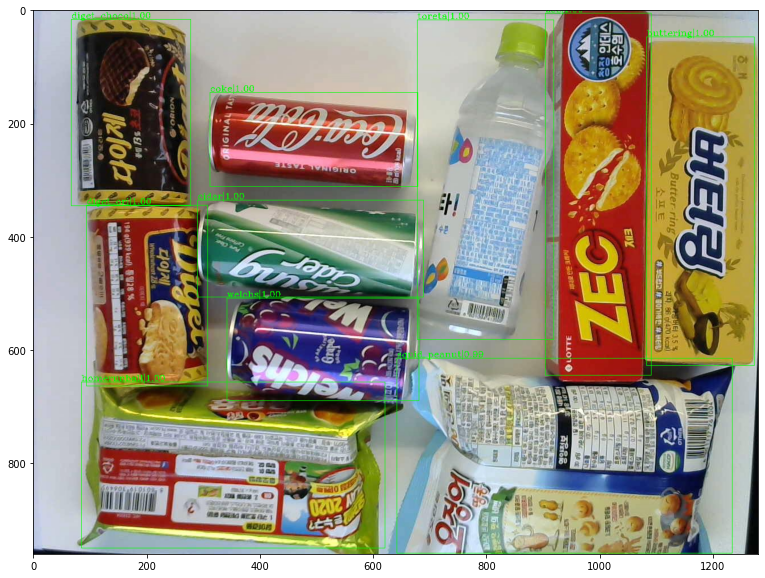

In [6]:
from mmdet.apis import inference_detector, show_result_pyplot
img = mmcv.imread('datasets/train/images/0046.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [7]:
torch.save(model.state_dict(), 'save_state_dict/CascadeRCNN_model_state_dict.pt')

In [8]:
torch.save(model, 'save_model/CascadeRCNN_model.pt')